# Solve Boltzmann Equation

This code write about solving the Boltzmann equation numerically.

## Preparation

In [2]:
import numpy as np
from scipy import integrate
from scipy import optimize
from scipy import interpolate
import scipy as sp
from matplotlib import pyplot as plt

Abs = np.abs
Log = np.log
Log10 = np.log10
Pi = np.pi
ArcTanh = np.arctanh
Sqrt = np.sqrt
Exp = np.exp
Cos = np.cos
Sin = np.sin
Arg = np.angle
BesselK = sp.special.kv
Zeta = sp.special.zeta
HeavisideTheta = lambda x: np.heaviside(x, 0)
Nnu = 3 # neutrino dof
GeV=1e3 # Use unit of MeV
mpl=1.22e19 * GeV
gstar=3.91
def H(T):
    return 1.66*np.sqrt(gstar)*T**2/mpl

def Plot(fun, xminmax, n=100,xfun=np.linspace):
    xlist = xfun(xminmax[0], xminmax[1], n)
    ylist = [fun(x) for x in xlist]
    plt.plot(xlist, ylist)

## Deal with Bessel functions

Bessel functions are bad for x > 550 since the exponential result is too small for python to handle. Let's use the taylor series for it, the performance should be good for large x.

In [3]:
x_Kmax = 550.

In [4]:
def BesselK1_Series(x):
    coefficient = np.exp(-x) * np.sqrt(Pi/2)
    first=x**(-0.5)
    second = 3/8 * x**(-1.5)
    third=-15/128 * x**(-2.5)
    forth = 105/1024 * x**(-3.5)
    return coefficient*(first+second+third+forth)
    
def BesselK2_Series(x):
    coefficient = np.exp(-x) * np.sqrt(Pi/2)
    first=x**(-0.5)
    second = 3/8 * x**(-1.5)
    third = 105/128 * x**(-2.5)
    forth = -315/1024 * x**(-3.5)
    return coefficient*(first+second+third+forth)

def BesselK_Series(n,x):
    coefficient = np.exp(-x) * np.sqrt(Pi/2)
    first=x**(-0.5)
    second = 3/8 * x**(-1.5)
    if n==1:
        third=-15/128 * x**(-2.5)
        forth = 105/1024 * x**(-3.5)
    elif n==2:
        third = 105/128 * x**(-2.5)
        forth = -315/1024 * x**(-3.5)
    return coefficient*(first+second+third+forth)

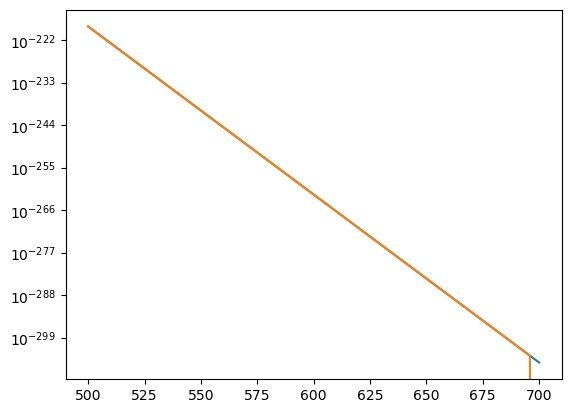

In [11]:
Plot(BesselK2_Series, (500,700))
Plot(lambda x: BesselK(2,x), (500,700))
plt.yscale('log')

So we can see that the Bessel function behaves badly at large x.

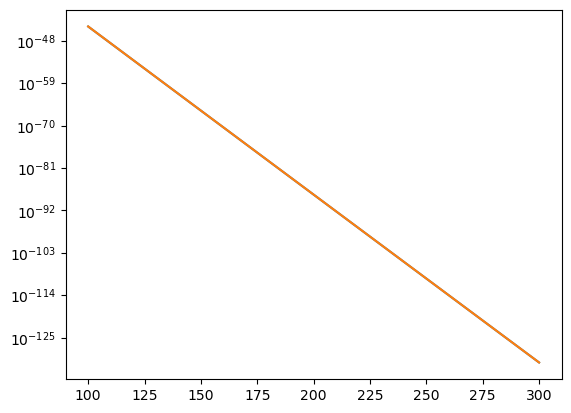

In [6]:
Plot(BesselK2_Series, (100,300))
Plot(lambda x: BesselK(2,x), (100,300))
plt.yscale('log')

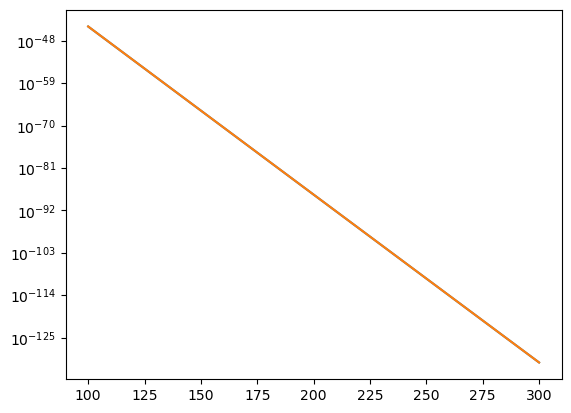

In [32]:
Plot(lambda x: BesselK(1,x), (100,300))
Plot(lambda x: BesselK(2,x), (100,300))
plt.yscale('log')

In [5]:
def BesselK_func(n,x):
    if x > x_Kmax:
        return BesselK_Series(n,x)
    else:
        return BesselK(n,x)

## Number density related to $T$ and $m$

The number density $n$ can be expressed by $T$ and $m$. However, since we are going to compute the scattering term in the Boltzmann equation as a function of temperature, we need to do this inversely, i.e. express temperature as a function of $n$.

We should compute the $n$ at first, then numerically solve it back.

In [6]:
def E_FD(E,m,T):
    return (E*(E**2 - m**2)**0.5)/(np.exp(E/T) + 1)
def n_FD(m,T):
    """
    Compute the number density from FD distribution.
    """
    return integrate.quad(lambda E: E_FD(E, m, T), m, 1e2*T)[0]/(2*Pi**2)
def E_BE(E,m,T):
    return (E*(E**2 - m**2)**0.5)/(np.exp(E/T) -1)
def n_BE(m,T):
    return integrate.quad(lambda E: E_BE(E, m, T), m, 1e2*T)[0]/(2*Pi**2)

def n_MB(m,T):
    return m**2 * T * BesselK_func(2, m/T)/(2*Pi**2)

In [13]:
n_MB(1e-4,1e-5)

1.0897000595362578e-19

In [70]:
n_FD(1,0.1)

1.0896840071998719e-07

In [13]:
np.vectorize(lambda T: n_BE(1, T))(0.1)

array(1.08971607e-07)

## Scattering cross sections

In [7]:
def σννχχ(mχ, mφ, yν, s):
    sigma = yν**4/(48*np.pi)
    sigma *= (s - mχ**2)
    sigma *= (s - mφ**2)**(-2)
    sigma *= (1 - 4*mχ**2/s)**0.5
    return sigma

def σχχνν(mχ, mφ, yν, s):
    sigma = yν**4/(48*np.pi)
    sigma *= (s - mχ**2)
    sigma *= (s - mφ**2)**(-2)
    sigma *= (1 - 4*mχ**2/s)**(-0.5)
    return sigma

## Solve everything

In [8]:
class model():
    def __init__(self,yν, mφ, mχ,amax=1e6):
        """Initialize the model.
        Input:
        - yν: portal coupling strength. Same strength for both neutrino-portal coupling and DM-portal coupling.
        - mφ: portal particle mass m_φ.
        - mχ: dark matter mass m_χ.
        """
        print("Model parameters input.")
        print("yν = " + str(yν) + ", mφ = " + str(mφ) + ", mχ = " + str(mχ))
        print("Initializing...")
        self.yν = yν
        self.mφ = mφ
        self.mχ = mχ
        self.g = 2 # dof of each Weyl fermion.
        self.Nχ = 1 # DM species
        self.Nν = 3 # neutrino species
        self.amax = amax
        self.Tχ_from_nχ, self.Tν_from_nν = self.__T_from_N__()
        self.gH = (8*Pi**3/90 * gstar)**0.5
        self.sol = None
        self.Tprod=32*self.mχ/(3*Pi**2)
        self.xprod = 3*Pi**2/32
        self.σv0=self.mχ**2 * self.yν**4/(8*Pi*(self.mφ**2-4*self.mχ**2)**2)
        self.lbda = mpl*self.mχ/self.gH * self.σv0
        self.xfo= None
        self.xeq = None
        self.freeze_out = None
        self.__in_or_out()
        if self.freeze_out:
            self.solve_xfo()
            self.solve_xeq()
    def __T_from_N__(self):
        """Solve for temperature T from number density n.
        Automatically called via initializing.
        Private function.
        """
        print("Initializing kinetic equilibrium distributions of χ and ν.")
        print("Scanning temperatures...")
        T_list = np.logspace(Log10(self.mχ)-2, Log10(self.mχ)+3,1000)
        n_v = np.vectorize(self.n_χ)
        n_list = Log10(n_v(T_list))
        T_from_n_χ = lambda n: 10**interpolate.interp1d(n_list, Log10(T_list), kind='cubic')(Log10(n))
        T_from_n_ν = lambda nν: (nν * 4/3 * Pi**2/Zeta(3) / self.g)**(1/3)
        print("Equilibrium done! Now you can compute temeperaure T from number density n for DM χ and neutrino ν!")
        return T_from_n_χ, T_from_n_ν
        
    def __in_or_out(self):

        if self.nχ_prod_ana(self.Tprod) >= self.n_χ(self.Tprod):
            # Maximal produced value larger than equilibrium one. Freeze-out case.
            self.freeze_out = True
            print("Coupling large enough for χ to enter equilibrium. Freeze-out case.")
        else:
            print("Coupling too small for χ to enter equilibrium. Freeze-in case.")

        
    def n_ν(self, T):
        """Neutrino number density as a function of T.
        Using MB distribution."""
        return 3/4 * Zeta(3)/np.pi**2 * self.g * T**3
    def n_χ(self, T):
        """DM number density as a function of T.
        Using MB distribution."""
        return self.g*n_MB(self.mχ, T)
    
    def nχ_prod_ana(self,T):
        """The produced density of χ at T."""
        return  mpl*self.Nν * T**2 * self.yν**4/(384*Pi**5*self.gH) # Initial
    
    def solve_xeq(self):
        assert self.freeze_out
        if self.xeq == None:
            def criteria(logx):
                T = self.mχ/10**logx
                return self.n_χ(T) - self.nχ_prod_ana(T)
            logxeq = optimize.brentq(criteria,-3,1)
            self.xeq = 10**logxeq

    def solve_xfo(self):
        """Solve the freeze-out point."""
        assert self.freeze_out
        if self.xfo == None:
            def fo_critiria(x):
                return x - Log(self.lbda/Pi**2/x**0.5)
            self.xfo = optimize.brentq(fo_critiria,0.01,100)
            print("The estimated freeze-out x value is "+ str(self.xfo))

    def yfo(self,x):
        """Return the n_χ/T^3 in the freeze-out regime."""
        assert self.freeze_out
        assert x >= self.xeq
        T = self.mχ/x
        if x <= self.xfo:
            return self.n_χ(T)/T**3
        elif self.xfo < x <= 2*self.xfo:
            Yf = self.n_χ(self.mχ/self.xfo)/(self.mχ**3/self.xfo**3)
            num = Yf * x
            deno = x * (self.lbda * Yf/self.xfo - 1)
            deno += self.xfo * (2-self.lbda * Yf/self.xfo)
            return num/deno
        else:
            Yinf = self.xfo/self.lbda
            return Yinf * x /(x - self.xfo)
        
    def yana(self,x):
        """Return the n_χ/T^3 for all cases."""
        T = self.mχ/x
        if self.freeze_out:
            if x < self.xeq:
                return self.nχ_prod_ana(T)/T**3
            else:
                return self.yfo(x)
        else:
            if x <= self.xprod:
                return self.nχ_prod_ana(T)/T**3
            else:
                return self.nχ_prod_ana(self.Tprod)/self.Tprod**3

    def Cννχχ(self, T):
        integral = integrate.quad(lambda s: σννχχ(self.mχ, self.mφ, self.yν, s) * s**1.5 * BesselK_func(1, s**0.5/T), 4*self.mχ**2,max(400*T**2, 100*self.mχ**2))[0]
        return T/(32*np.pi**4)*integral

    def Cχχνν(self, T):
        integral = integrate.quad(lambda s: σχχνν(self.mχ, self.mφ, self.yν, s) * s**0.5 * (s - 4 * self.mχ**2) * BesselK_func(1, s**0.5/T), 4*self.mχ**2,max(400*T**2, 100*self.mχ**2))[0]
        return T/(32*np.pi**4)*integral

    
    def dYda(self, a, Y):
        """
        Right side of the Boltzmann equation.
        To be called by integrate.solve_ivp.
        """
        a2, a3 = a**2, a**3
        nχ, nν = Y[0]/a3, Y[1]/a3
        Tχ = self.Tχ_from_nχ(nχ)
        Tν = self.Tν_from_nν(nν)

        Cpχ = self.Nν * self.Cννχχ(Tν)
        Cdχ = self.Nν * self.Cχχνν(Tχ)

        Cpν = self.Nχ * self.Cχχνν(Tχ)
        Cdν = self.Nχ * self.Cννχχ(Tν)
        T0 = self.mχ * 1e3
        HT = H(T0*10/a)
        dY = np.array([
            a2/HT * (Cpχ - Cdχ), a2/HT * (Cpν - Cdν)
        ])
        return dY
    
    def solveBoltzmann(self):
        if self.sol == None:
            T0 = self.mχ * 1e3
            nχ0 = self.nχ_prod_ana(T0) # Initial value of χ, determined from analytical expression.
            print("Initial χ density: " + str(nχ0))
            initial=np.array([nχ0*1e3, self.n_ν(T0)*1e3])
            print("Initial ν density: " + str(self.n_ν(T0)))
            points=np.logspace(1, Log10(self.amax),3000)
            result = integrate.solve_ivp(self.dYda,(10,self.amax+0.1), initial,method="BDF",t_eval=points)
            self.sol = result
    

In [42]:
m = model(1e-5,0.1*1e-3, 0.1*1e-3)

Model parameters input.
yν = 1e-05, mφ = 0.0001, mχ = 0.0001
Initializing...
Initializing kinetic equilibrium distributions of χ and ν.
Scanning temperatures...
Equilibrium done! Now you can compute temeperaure T from number density n for DM χ and neutrino ν!
Coupling large enough for χ to enter equilibrium. Freeze-out case.
The estimated freeze-out x value is 4.376680866640802


In [43]:
m.solveBoltzmann()

Initial χ density: 9.487757393423009e-06
Initial ν density: 0.00018269074235035968


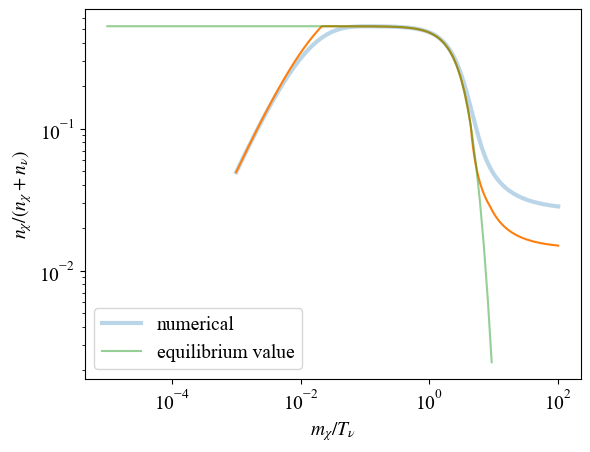

In [44]:
rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
plt.rcParams["font.size"] = 14
nχ = m.sol.y[0]/m.sol.t**3
nν = m.sol.y[1]/m.sol.t**3
Tν = m.Tν_from_nν(nν)
m_over_Tν = m.mχ/Tν
plt.plot(m_over_Tν,nχ/(nχ+nν),label='numerical',lw=3,alpha=0.3)
yanalist = np.array([m.yana(x) for x in m.mχ/Tν])
nχana = yanalist*Tν**3
plt.plot(m_over_Tν, nχana/(nχana+nν))
Tplot2=np.logspace(Log10(m.Tprod)-1,1,100)
nχeq= np.array([m.n_χ(T) for T in Tplot2])
plt.plot(m.mχ/Tplot2,nχeq/(nχeq+m.n_ν(Tplot2)),label='equilibrium value',alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$m_\chi/T_\nu$')
plt.ylabel(r'$n_\chi/(n_\chi+n_\nu)$')
plt.legend()

We can see that the analytical expression agrees with the production curve. And:
- The stopping point T_prod computed analytically agrees with numerical solution.
- The freeze-out happens, but the equilibrium time is very short. This actually agrees with the Mathematica computation.
- A problem: for the freeze-out regime, the numerical solution does not agree with the analytical expression. However, the analytical expression does agree with the numerical solution to the equation for Y and sigma*v, see mathematica .nb. Maybe some problem happens in the numerical computation here.